# Analysis Notebook

#### Imports and settings

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

import requests
from pandas.io.json import json_normalize

import seaborn as sns
from bokeh.plotting import figure
from bokeh.io import push_notebook, output_file, output_notebook, show
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.palettes import Plasma256, linear_palette

from sklearn.cross_validation import train_test_split

#MaxAbsScaler for Sparse, StandardScaler otherwise
from sklearn.preprocessing import StandardScaler
#from sklearn.preprocessing import MaxAbsScaler

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from treeinterpreter import treeinterpreter as ti

from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import accuracy_score


In [32]:
pd.set_option('display.max_columns', None)
pd.options.display.max_rows = 160

plt.style.use('ggplot')

#sns.set_palette('husl', n_colors=20)

### Functions for querying and capturing data

In [ ]:
def yummly_search(query, page=1, n=400, start=0):

    """ Search yummly for ingredient or recipe name."""

    url = ('http://api.yummly.com/v1/api/recipes?_app_id=' + yummly_api + 
           '&_app_key=' + yummly_key + '&q=' + query + '&maxResult=' + str(n) + 
           '&start=' + str(start))

    return requests.get(url).json()

In [ ]:
def get_yummly_recipe(id):

    """ Request full recipe data for individual recipe """
    
    url = ('http://api.yummly.com/v1/api/recipe/' + id + '?_app_id=' +
           yummly_api + '&_app_key=' + yummly_key)
    
    return requests.get(url).json()

In [ ]:
# List of query terms to use in yummly_search()
yummly_list = ['beef', 'chicken', 'oats', 'corn', 'pasta', 'rice',
               'flour', 'potatoes', 'tomatoes', 'beans', 'apples',
               'milk', 'pork', 'fish', 'eggs', 'broccoli',
               'carrots', 'fruit', 'cheese', 'shrimp', 'butter', 'oil']

In [ ]:
def end_capture(query, n=400):

    """ Jump to end of query list to balance recipe ratings """
    
    head = yummly_search(query)
    end = head['totalMatchCount'] - (2 * n)

    return json_normalize(yummly_search(query, n=n, start=end), 'matches')

In [ ]:
def yummly_multi_recipe(n=10):

    """ Scripted multiple calls to get_yummly_recipe() to download full dataset """
    
    recipes = pd.read_pickle(path + '/yum_recipes3')
    start = recipes.index.max()
    try:
        while (recipes.index.max() < (start+n)):
            recipes = recipes.append(json_normalize(get_yummly_recipe(
                    remaining.iloc[len(recipes)])), ignore_index=True)
        recipes.to_pickle(path + '/yum_recipes3')
    except:
        recipes.to_pickle(path + '/yum_recipes3')
        print('**Error at %i **' % recipes.index.max())
        
    return recipes.index.max()

In [ ]:
def yummly_skip_recipe(n=1):

    """ Function to skip problematic recipe result after exception from yummly_multi_recipe()"""
    
    recipes = pd.read_pickle(path + '/yum_recipes3')
    start = recipes.index.max()
    while (recipes.index.max() < (start+n)):
        recipes = recipes.append(json_normalize(get_yummly_recipe(
                remaining.iloc[len(recipes)]+1)), ignore_index=True)
    
    recipes.to_pickle(path + '/yum_recipes3')
    
    return recipes.index.max()

### Recipes were collected using above functions and a subset is shown below for illustration

In [ ]:
recipes = pd.read_pickle('/home/mike/Documents/springboard/capstone_data/scraper/yum_recipes3')

In [ ]:
recipes.head(2)

### Nutrition information is primarily contained in the 'nutritionEstimates' column.  The structure is shown below.  This field was then parsed into individual columns and appended to the 'id'.  

### Rating information was remapped to '0' (low ratings of 0-3) or '1' (high ratings of 4-5) and stored as 'class_label'.

In [ ]:
#nutrients = [record['attribute'] for record in recipes.nutritionEstimates[3633]]

#q = pd.DataFrame(columns=nutrients)

#for row in recipes.nutritionEstimates:
#    t = pd.Series({attribute['attribute']: attribute['value'] for attribute in row})
#    q = q.append(t, ignore_index=True)

# Recipe rating information contained in recipe list '/yum_recipes3'.
#recipes = recipes.append(pd.read_pickle(path + '/yum_recipes3'), ignore_index=True) 

#data = pd.read_csv(path + '/FinalYumData.csv')
#data = data.drop('Unnamed: 0', axis='columns')
#data['class_label'] = data.rating.map(lambda x: 1 if x>3 else 0)
#data.drop('rating', axis=1, inplace=True)

In [ ]:
recipes.iloc[0]['nutritionEstimates']

### Finally, the DataFrame was saved as a csv for future use.  Note that NaNs in each recipe's nutrient values were filled with '0'.

In [4]:
data = pd.read_csv('/home/mike/Documents/springboard/capstone_data/scraper/yum_data.csv', low_memory=False)

# Data Exploration

In [ ]:
data.shape

In [ ]:
pd.Series(data.columns)

### Drop non-nutritional / redundant features

In [ ]:
#data.drop(['Unnamed: 0', 'numberOfServings', 'totalTimeInSeconds'], axis=1, inplace=True)

In [5]:
#drop any rows with all zeros
data = data.dropna(axis=0)

In [ ]:
data.head(2)

In [ ]:
data.shape

### Collect nutrients only and scale to single serving

In [6]:
#collect just nutrients as variable 'features' and scale to single serving
features = data.iloc[:,4:].divide(data.numberOfServings, axis=0)

In [ ]:
#example record
features.iloc[3145]

### Check for feature correlation with recipe rating (class_label)
While no strong correlations exist, a number of features are negatively correlated with ratings (coefficient ~ -0.1).  

In [7]:
features.corrwith(data.class_label).sort_values(ascending=False)

THEBRN                        0.040029
CAFFN                         0.019839
Vitamin E, added              0.016456
GALS                          0.012844
CARTA                         0.012578
HYP                           0.012367
18:2 i                        0.012351
F22D0                         0.011063
18:3i                         0.007647
FLD                           0.006448
FATRNP                        0.006373
SUCS                          0.006041
CU                            0.004288
F24D0                         0.003477
LACS                          0.003200
THIA                          0.002240
MN                            0.001173
F24D1C                        0.001076
F8D0                          0.001027
CYS_G                         0.000873
F17D0                        -0.002469
F16D1C                       -0.002469
RETOL                        -0.003427
TOCPHD                       -0.003460
STID7                        -0.003565
CRYPX                    

### Examine statistics for each feature.  
Note that many contain zeros through 50th or even 75th percentile.

In [8]:
features.describe()

,FAT_KCAL,K,FLD,PHYSTR,VAL_G,SITSTR,F18D1C,F18D2CN6,FASAT,STARCH,FOLDFE,THIA,MN,GLUS,ARG_G,F16D1,ALA_G,FOLFD,FE,ENERC_KJ,VITB6A,ASP_G,F18D3CN3,FRUS,TOCPHA,WATER,SUGAR,FAMS,GLY_G,ASH,SE,FIBTG,PROCNT,PHE_G,CHOCDF,FOL,VITK,F18D0,LEU_G,LYCPN,LUT+ZEA,CARTA,F20D0,CHOLE,STID7,CU,TOCPHG,P,PANTAC,CHOLN,CA,MG,CAMD5,FAPU,F14D0,VITA_RAE,NIA,CRYPX,GLU_G,F16D0,F18D1,F18D2,BETN,FOLAC,SUCS,CARTB,LYS_G,F18D3,SER_G,TOCPHD,VITA_IU,F20D1,ENERC_KCAL,VITC,RIBF,FAT,PRO_G,ZN,NA,FATRN,HISTN_G,ILE_G,MALS,RETOL,THR_G,TYR_G,VITB12,VITD-,GALS,F10D0,F12D0,F16D1C,F17D0,F18D1T,F4D0,F6D0,F8D0,MET_G,ALC,18:2 i,18:3i,FATRNP,F22D0,F24D0,Adjusted Protein,LACS,TOCPHB,FATRNM,TRP_G,CYS_G,F22D1,F24D1C,22:1 c,F22D6,CAFFN,F20D5,18:2 t not further defined,HYP,F20D4,THEBRN,"Vitamin B-12, added","Vitamin E, added"
count,20936.000000,20936.000000,2.093600e+04,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,2.093600e+04,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.0,20936.000000,20936.000000,2.093600e+04,20936.000000,20936.00000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.0,20936.000000,20936.000000,20936.000000,20936.000000,20936.0,20936.0,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.00000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.0,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.0,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,2.093600e+04,20936.000000,20936.000000,20936.0,20936.000000,20936.000000,20936.000000,20936.000000,20936.00000,20936.00000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.0,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.000000,20936.0,20936.000000
mean,51.688091,0.158001,1.194115e-07,0.004962,0.191128,0.002464,0.553186,0.235335,2.150194,1.873024,25.436620,9.552923e-07,0.000025,0.448466,0.198778,0.087854,0.169792,0.0,0.000607,437.839596,8.358808e-07,0.329903,0.03720,0.487208,0.000271,53.119741,3.214496,2.223650,0.137298,0.906477,0.0,1.160245,4.502257,0.183827,9.855016,0.0,0.0,0.420575,0.296943,0.000177,0.000054,0.000001,0.006006,0.022128,0.000033,0.000001,0.00018,0.070333,0.000020,0.016822,0.039110,0.016543,0.001076,0.812955,0.221481,42.907068,0.001166,0.000001,0.764286,1.008483,2.039485,0.666212,0.004162,0.0,1.052384,0.000125,0.262183,0.062187,0.188780,0.000003,503.947984,0.006944,107.886186,0.006824,0.0,5.741437,0.241300,0.000259,0.154772,0.025008,0.109936,0.185939,0.039695,7.562731e-07,0.149837,0.118120,0.0,8.443127,0.008358,0.066244,0.191112,0.01010,0.01010,0.035442,0.063247,0.031850,0.033688,0.079385,0.145904,0.001383,0.001211,0.004079,0.002224,0.000254,0.013144,0.048296,0.0,0.005264,0.002647,0.000349,0.001687,0.000109,0.000488,0.008598,0.000140,0.002420,0.000288,0.000044,0.000549,0.000849,0.0,0.000003
std,95.048462,0.229602,1.727799e-05,0.014586,0.338117,0.014517,2.307237,1.419981,4.380056,6.169444,57.137002,7.726545e-05,0.000404,1.377035,0.375387,0.220550,0.315109,0.0,0.001779,685.815683,5.182846e-05,0.583052,0.24475,1.825133,0.001542,83.691683,8.542039,4.586118,0.282916,1.349205,0.0,2.097951,6.961119,0.334586,18.816439,0.0,0.0,0.887800,0.525608,0.001046,0.000573,0.000077,0.040031,0.047709,0.000450,0.000088,0.00129,0.106189,0.000311,0.030888,0.074559,0.029192,0.007323,2.296749,0.597578,89.072766,0.002419,0.000075,1.253335,1.973240,4.330981,1.989229,0.015476,0.0,5.142429,0.000661,0.49555

### Evaluate nutrients by quantile to identify potential classification features.

In [68]:
q = pd.DataFrame(columns=features.columns)

#### Calculate percentage of recipes with high ratings across deciles.
Fraction of positively ranked recipes in each bin is

$\frac{positive}{all} = \frac{(1\times n_{pos})+(0\times n_{neg})}{(n_{pos} + n_{neg})} = \frac{\Sigma \textit{ class_label}}{n_{tot}} = mean(\it{class\_label})$

Decile distribution is calculated (using $\textit{rank}$ method to avoid non-unique bin-edge exception, and mean(class_label) is calculated for each decile and nutrient using groupby:

In [69]:
for column in features.columns:
    sub = data[[column, 'class_label']]
    bins = pd.cut(sub[column].rank(method='first'), 10, labels=False)  #calculate decile bins for each column
    grouped = sub.groupby([bins])                                      #groupby bins
    q[column] = grouped.mean().class_label                             #calculate mean(class_label) for each decile

In [70]:
q.index.name = 'PERCENTILE'            #rename index for use in unstacking/melting dataframe

### Visualize fraction of recipes with positive ratings across deciles (subset shown):
Note that each nutrient displays a subset of deciles where the portion of negative ratings sharply increases which can be used to pre-evaluate recipes, or adjust contents during recipe development.

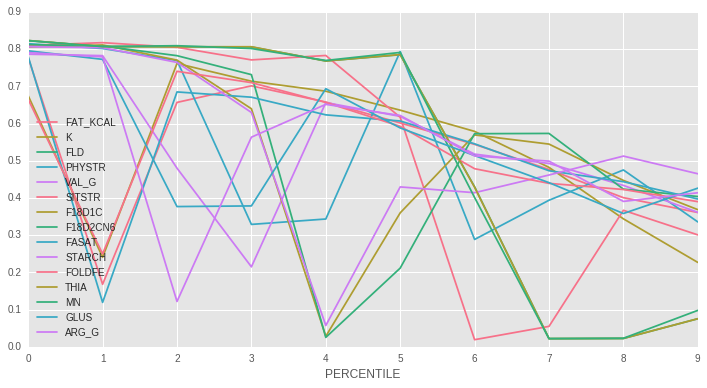

In [71]:
q.iloc[:,:15].plot(figsize=(12,6))

### Look at pairwise comparisons of nutrients' positive ratings
Note that histograms of individual nutrients do not show particular per-serving amounts with significant indicators.

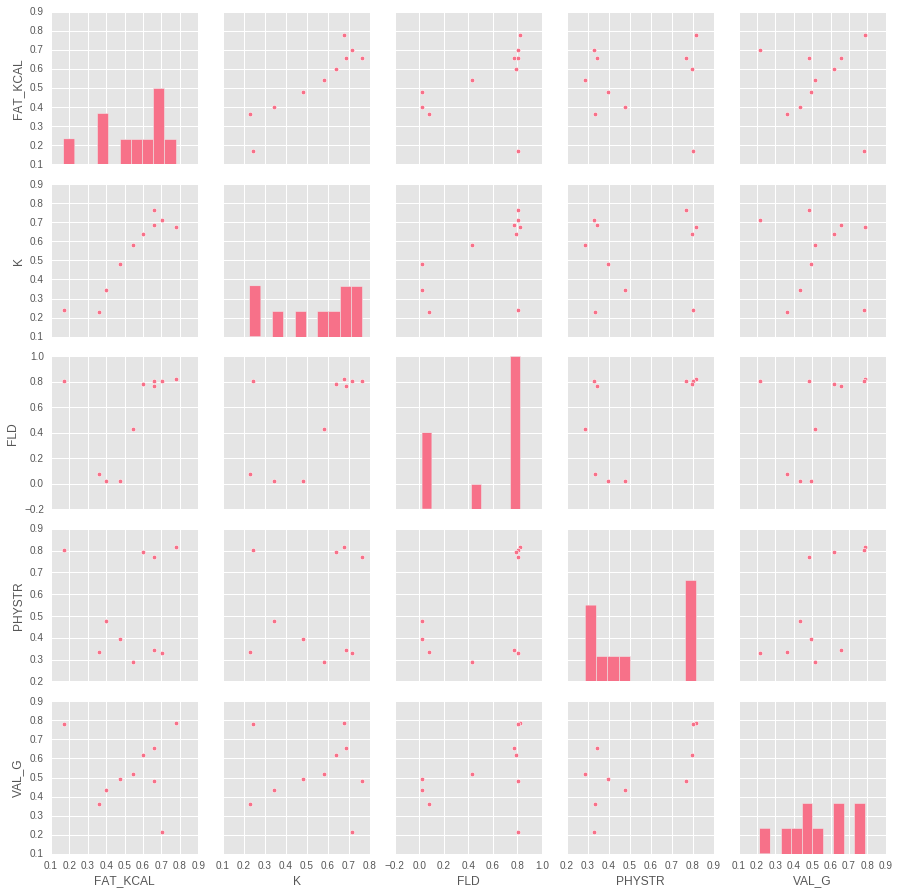

In [12]:
sns.pairplot(q.iloc[:,:5])

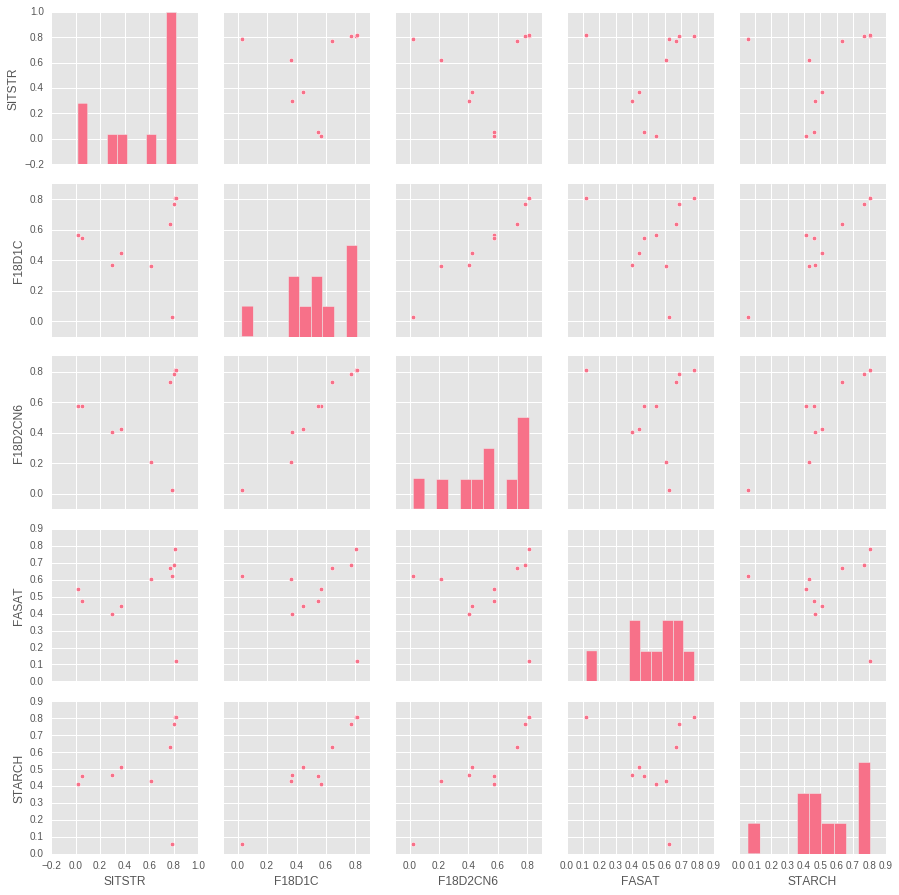

In [13]:
sns.pairplot(q.iloc[:,5:10])

In [ ]:
sns.pairplot(q.iloc[:,10:15])

In [ ]:
sns.pairplot(q.iloc[:,15:20])

In [ ]:
sns.pairplot(q.iloc[:,20:25])

In [ ]:
sns.pairplot(q.iloc[:,25:30])

In [ ]:
sns.pairplot(q.iloc[:,30:35])

In [ ]:
sns.pairplot(q.iloc[:,35:40])

In [ ]:
sns.pairplot(q.iloc[:,40:45])

In [ ]:
sns.pairplot(q.iloc[:,45:50])

### Visualize full set of decile patterns

In [73]:
q['Decile'] = np.arange(1, 11, 1)

In [74]:
u = pd.melt(q, id_vars='Decile', var_name='nutrient')

In [75]:
u.columns

Index(['Decile', 'nutrient', 'value'], dtype='object')

In [76]:
u

,Decile,nutrient,value
0,1,FAT_KCAL,0.777459
1,2,FAT_KCAL,0.168099
2,3,FAT_KCAL,0.656952
3,4,FAT_KCAL,0.701528
4,5,FAT_KCAL,0.657907
5,6,FAT_KCAL,0.601719
6,7,FAT_KCAL,0.544195
7,8,FAT_KCAL,0.476600
8,9,FAT_KCAL,0.400860
9,10,FAT_KCAL,0.361032


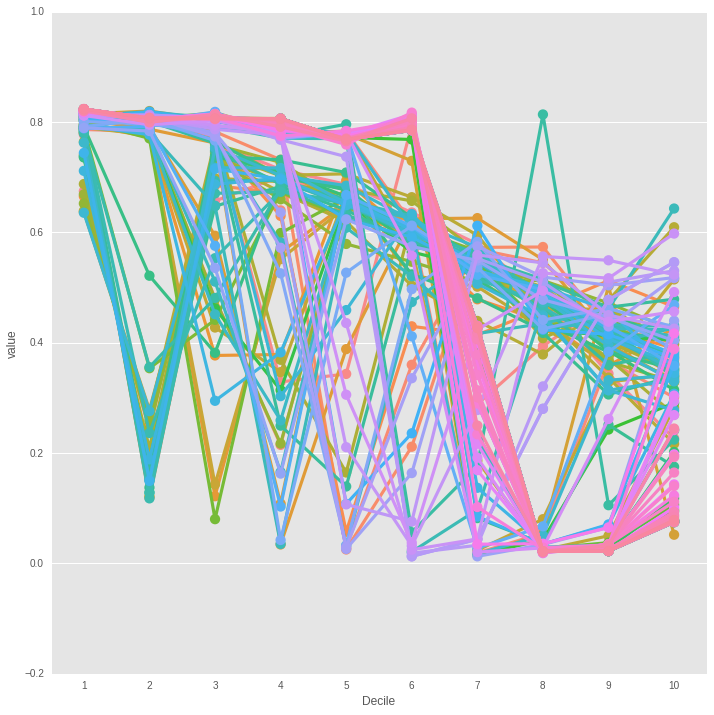

In [77]:
g = sns.factorplot(x='Decile', y='value', hue='nutrient', data=u, legend=False, size=10)

### Redo visualization with Bokeh to allow drill-down into particular features

In [14]:
output_notebook()
#output_file('lines.html')

TOOLS = 'pan,wheel_zoom,reset,tap,hover'
numlines = len(q.columns)
mypalette=linear_palette(Plasma256, numlines)

hover = HoverTool(
        tooltips=[
            ("index", "$index"),
            ("(x,y)", "($x, $y)")])

z = figure(plot_width=900, plot_height=600, title=None, tools=TOOLS)

z.multi_line(xs=[q.index.values]*numlines,
             ys=[q[name].values for name in q],
            line_color=mypalette,
            line_width=3)



Loading BokehJS ...

GlyphRenderer(id='f1b27885-4026-4611-b250-66979941734e', ...)

In [15]:
show(z)

# Data preprocessing

### Split training and test data from dataset.  
X is the nutrient quantity for each recipe.  y is the class label for each recipe.


In [16]:
X = features
y = data.class_label

In [79]:
X.shape

(20936, 122)

In [80]:
y.shape

(20936,)

In [17]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=97)

### Data must be scaled for Logistic Regression. 
Scikit-learn's standard scaler applied to single-serving data:

In [18]:
scl = StandardScaler()  #or MAS

X_train_scl = scl.fit_transform(X_train)
X_test_scl = scl.transform(X_test)

## Logistic Regression

Initial classification with Logistic Regression was attempted with C=1 and L1 regularization (due to sparsity of many nutrients) with successful convergence and acceptable results.  Several other values of C were tested with little impact to accuracy and other metrics.  L2 regularization was also tested with little impact.  

In [19]:
cl = LogisticRegression(C=0.1, penalty='l1', n_jobs=-1)

In [81]:
cl.fit(X_train_scl, y_train)  #use scaled X values

LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=-1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

### Logistic Regression weights were calculated and identified to provide insight to key nutrients

In [82]:
lr_weights = pd.Series(cl.coef_[0,:], index=features.columns)

In [22]:
lr_weights.sort_values(ascending=False)

LYS_G                         0.985946
TYR_G                         0.692440
F6D0                          0.539042
ASP_G                         0.538691
F18D3CN3                      0.358869
VAL_G                         0.284110
F18D1                         0.225807
FATRNM                        0.222237
MG                            0.207923
SUGAR                         0.200507
F18D1T                        0.191461
F17D0                         0.167519
CARTB                         0.165178
CHOLN                         0.152419
NA                            0.151508
LEU_G                         0.150622
F18D2                         0.125352
FOLDFE                        0.119466
F10D0                         0.113267
CA                            0.111748
FRUS                          0.109883
F14D0                         0.108459
STARCH                        0.102065
LACS                          0.097449
CARTA                         0.097329
F16D1C                   

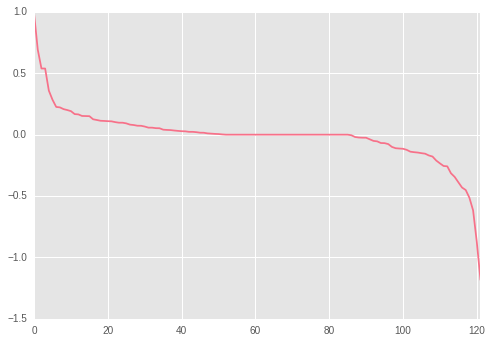

In [23]:
pd.DataFrame(cl.coef_).iloc[0,:].sort_values(ascending=False).plot(use_index=False)

### Performance

Performance is first viewed as a confusion matrix to understand distribution of correct and incorrect classifications.

In [94]:
y_pred_lr = cl.predict(X_test_scl)  #use test set scaled using the same transform as the training set

In [36]:
confmat_lr = confusion_matrix(y_true=y_test, y_pred=y_pred_lr)
confmat_lr

array([[ 842, 1088],
       [ 284, 1974]])

Confusion matrix shows significant number of false positives (incorrectly classified as highly rated).

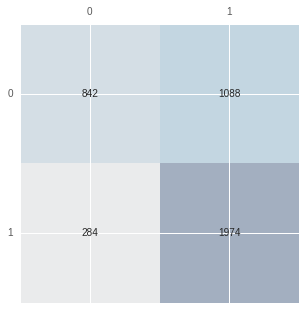

In [37]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat_lr, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat_lr.shape[0]):
    for j in range(confmat_lr.shape[1]):
        ax.text(x=j, y=i, s=confmat_lr[i, j], va='center', ha='center')

### Other performance metrics:  Accuracy, Precision, Recall, F1, and Area Under ROC Curve

In [38]:
accuracy_score(y_true=y_test, y_pred=y_pred_lr)

0.67239732569245458

In [39]:
precision_score(y_true=y_test, y_pred=y_pred_lr)

0.64467668190725014

In [40]:
recall_score(y_true=y_test, y_pred=y_pred_lr)

0.87422497785651021

In [41]:
f1_score(y_true=y_test, y_pred=y_pred_lr)

0.74210526315789482

In [42]:
y_score_lr = cl.predict_proba(X_test_scl)

In [43]:
roc_auc_score(y_test, y_score_lr[:,1])

0.70025195390482664

### Visualization using ROC curve

In [44]:
fpr_lr, tpr_lr, thresholds = roc_curve(y_test, y_score_lr[:,1], pos_label=1)

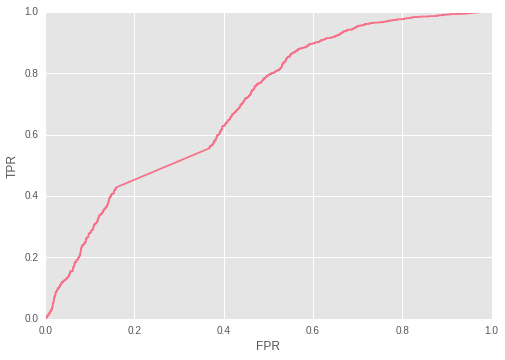

In [45]:
plt.plot(fpr_lr, tpr_lr)
plt.xlabel('FPR')
plt.ylabel('TPR')

# Random Forest
The random forest uses the original training set (scaled only to per-serving quantities and no across-feature scaling).

In [24]:
rfc = RandomForestClassifier(n_estimators=10000, max_features='sqrt', random_state=1, n_jobs=-1)

In [25]:
%%time
rfc.fit(X_train, y_train)

CPU times: user 9min 9s, sys: 1.26 s, total: 9min 10s
Wall time: 2min 24s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10000, n_jobs=-1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

### Examine top features (most important) to understand how ratings are distributed

In [30]:
eda = pd.DataFrame(data, columns=importances.Feature[:5])
eda['label'] = data.class_label

In [83]:
sns.set_palette('husl', n_colors=5)
sns.set(style='ticks', color_codes=True)

In [93]:
eda[(eda.STARCH>500)]

Feature,WATER,VITA_IU,K,STARCH,FIBTG,label
1873,774.25,296.05,0.43,757.11,1.02,1


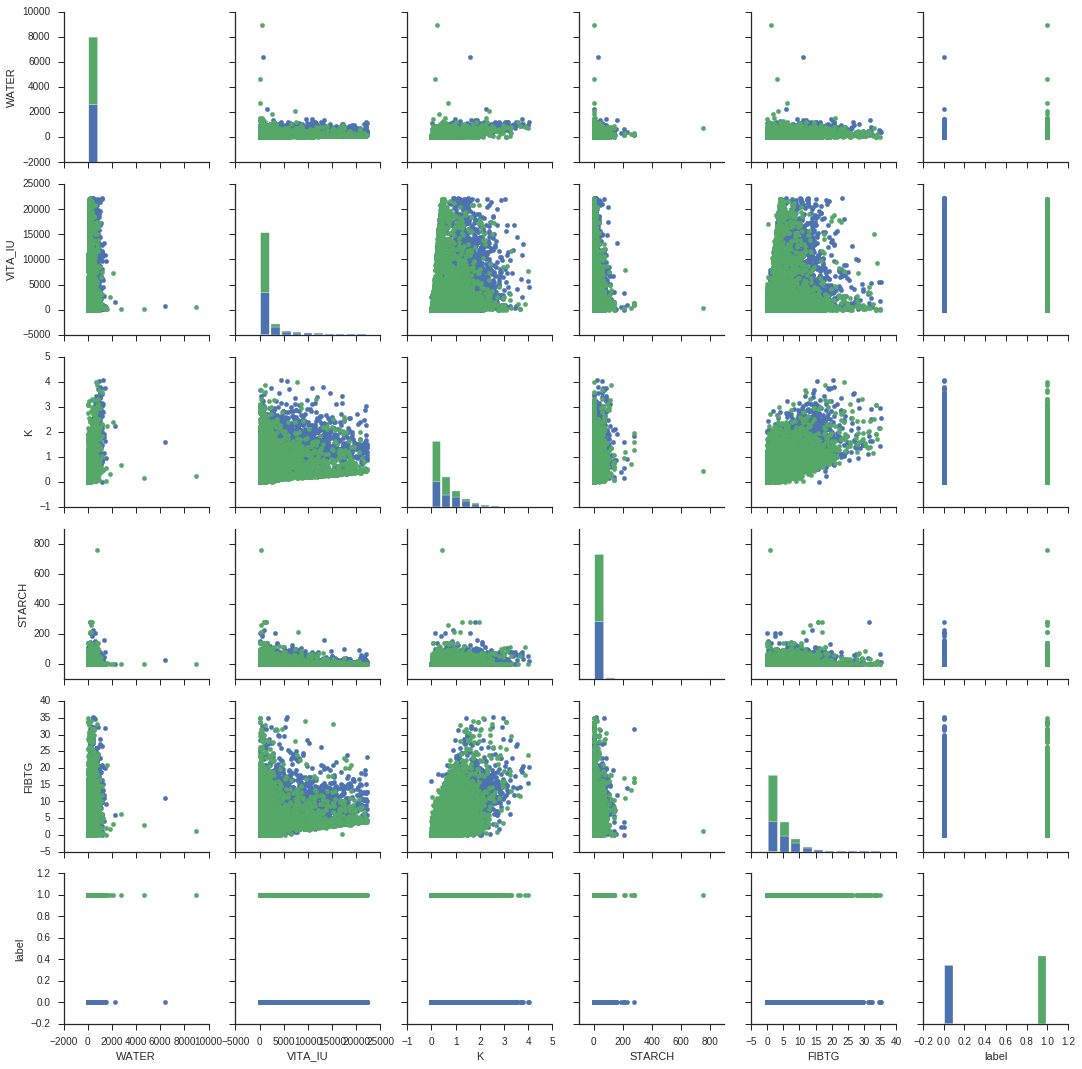

In [92]:
grid = sns.PairGrid(eda, hue='label')
grid = grid.map_diag(plt.hist)
#grid = grid.map_lower(sns.kdeplot, cmap='Blues_d')
grid = grid.map_offdiag(plt.scatter)

### RF Performance
Identical analysis as presented above.

In [46]:
y_pred = rfc.predict(X_test)
confmat = confusion_matrix(y_true=y_test, y_pred=y_pred)
confmat

array([[1335,  595],
       [ 496, 1762]])

Confusion matrix demonstrates much better performance than Logistic Regression in terms of False Positives and True Negatives.

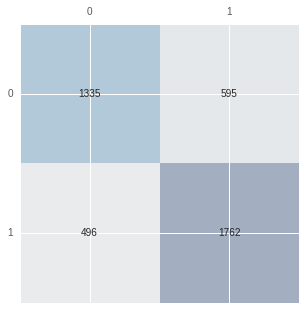

In [47]:
fig, ax = plt.subplots(figsize=(5, 5))
ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
    for j in range(confmat.shape[1]):
        ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')

In [48]:
accuracy_score(y_true=y_test, y_pred=y_pred) # vs LR:.67

0.73949379178605534

In [49]:
precision_score(y_true=y_test, y_pred=y_pred) # vs LR:.64

0.7475604582095885

In [50]:
recall_score(y_true=y_test, y_pred=y_pred) # vs LR:.87

0.78033658104517267

In [51]:
f1_score(y_true=y_test, y_pred=y_pred) # vs LR:.74

0.76359696641386787

In [52]:
y_score = rfc.predict_proba(X_test)

In [53]:
roc_auc_score(y_test, y_score[:,1]) # vs LR:.70

0.80280315929085755

In [54]:
fpr, tpr, thresholds = roc_curve(y_test, y_score[:,1], pos_label=1)

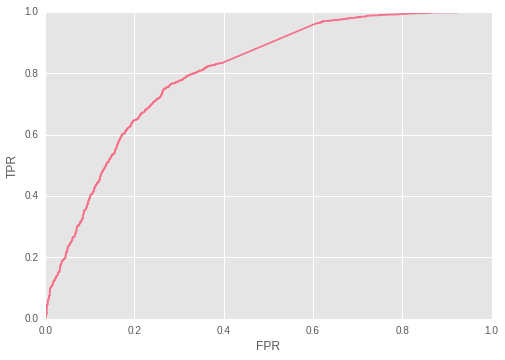

In [55]:
plt.plot(fpr, tpr)
plt.xlabel('FPR')
plt.ylabel('TPR')

### Identify trees for successful classifications
Using TreeInterpreter (pip installable)

In [56]:
rfc.estimators_[0]   #examine structure of information from individual trees

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features='sqrt', max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=1791095845, splitter='best')

Collect samples with highest probability to be positively rated using .predict_proba()

In [58]:
probs = pd.Series(rfc.predict_proba(X_test)[:,1])  

In [59]:
top = probs.sort_values(ascending=False).index[:10]

In [60]:
rfc.predict_proba(X_test)[:,1].argmax()

3145

In [62]:
# TreeInterpreter uses prediction probabilities and 
prediction, bias, contributions = ti.predict(rfc, X_test.iloc[top])

In [63]:
prediction

array([[ 0.0089    ,  0.9911    ],
       [ 0.0118    ,  0.9882    ],
       [ 0.0198    ,  0.9802    ],
       [ 0.02073667,  0.97926333],
       [ 0.0253    ,  0.9747    ],
       [ 0.0255    ,  0.9745    ],
       [ 0.027     ,  0.973     ],
       [ 0.029     ,  0.971     ],
       [ 0.0373    ,  0.9627    ],
       [ 0.0398    ,  0.9602    ]])

In [64]:
bias

array([[ 0.46645079,  0.53354921],
       [ 0.46645079,  0.53354921],
       [ 0.46645079,  0.53354921],
       [ 0.46645079,  0.53354921],
       [ 0.46645079,  0.53354921],
       [ 0.46645079,  0.53354921],
       [ 0.46645079,  0.53354921],
       [ 0.46645079,  0.53354921],
       [ 0.46645079,  0.53354921],
       [ 0.46645079,  0.53354921]])

In [65]:
contributions

array([[[ -3.52737749e-03,   3.52737749e-03],
        [ -2.34577483e-02,   2.34577483e-02],
        [  0.00000000e+00,   0.00000000e+00],
        ..., 
        [ -1.75540621e-04,   1.75540621e-04],
        [  0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00]],

       [[ -5.66249414e-03,   5.66249414e-03],
        [ -2.38677613e-02,   2.38677613e-02],
        [  0.00000000e+00,   0.00000000e+00],
        ..., 
        [  8.58244065e-05,  -8.58244065e-05],
        [  0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00]],

       [[ -4.00171813e-03,   4.00171813e-03],
        [ -1.76574161e-02,   1.76574161e-02],
        [  0.00000000e+00,   0.00000000e+00],
        ..., 
        [ -5.17291427e-06,   5.17291427e-06],
        [  0.00000000e+00,   0.00000000e+00],
        [  0.00000000e+00,   0.00000000e+00]],

       ..., 
       [[ -7.40448030e-03,   7.40448030e-03],
        [ -1.68994460e-02,   1.68994460e-02],
        [  0.000000

In [66]:
contributions.shape

(10, 122, 2)

### Each instance below shows a tree that classified a test sample as highly rated with high probability, and the relative importances of its features.

In [67]:
# following TI documentation example:

for i in range(len(top)):
    print( "Instance", i)
    print("Bias (trainset mean)", bias[i])
    print( "Feature contributions:")
    for c, feature in sorted(zip(contributions[i,:,1], features.columns),
                            key=lambda x: -abs(x[0])):
        print(feature, c)
    print( "-"*20 )

Instance 0
Bias (trainset mean) [ 0.46645079  0.53354921]
Feature contributions:
WATER 0.0297230609843
K 0.0234577483472
VITC 0.0210184822917
FIBTG 0.016075210713
ASH 0.0153296543016
STARCH 0.0145009568889
ENERC_KCAL 0.0124661522115
P 0.0123517815773
ENERC_KJ 0.0123207070062
PROCNT 0.0115510020381
FAMS 0.0108348274686
CA 0.0102451425114
NA 0.0101369513012
F18D1 0.00976290560722
MG 0.0095554785114
CHOCDF 0.0095208660903
18:2 i 0.00887535223802
FOLDFE 0.00827840485858
FASAT 0.00816630024779
VITA_IU 0.00812062093559
F16D0 0.00793053034337
FAT 0.00726470163698
SITSTR 0.00692065138205
VITA_RAE 0.00687694292027
CHOLN 0.00638864475722
CAMD5 0.00619709544214
18:3i 0.00618626810409
GLU_G 0.00608618521434
HISTN_G 0.00597309064863
F18D1C 0.00584728288838
F18D2CN6 0.00565305223568
FATRN 0.00551835018683
FAPU 0.00537188057958
F18D2 0.00534245456979
SER_G 0.00522638850968
VITD- 0.00497584377397
FE 0.00495668385629
LEU_G 0.00489252780681
F18D0 0.00456111621799
F16D1 0.00450758296876
GLY_G 0.004385658

### Individual tree feature importances are aggregated up to present the overall feature importances from the ensemble

In [26]:
feature_list = pd.Series(X.columns)

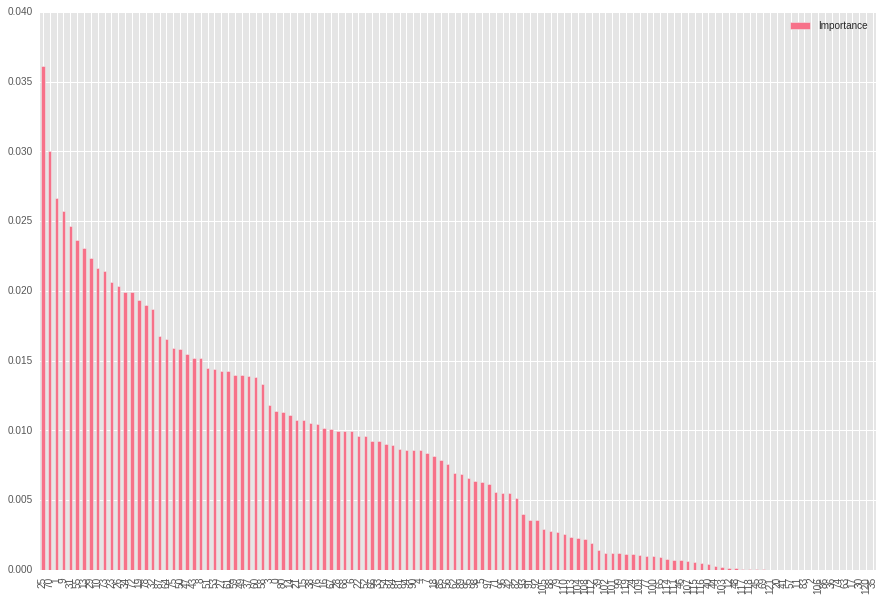

In [27]:
# Select features if needed
importances = pd.DataFrame({'Feature':feature_list,
                            'Importance':rfc.feature_importances_})
importances.sort_values(by='Importance', ascending=False).plot(kind='bar', figsize=(15,10))

In [28]:
importances = importances.sort_values(by='Importance', ascending=False)

In [29]:
importances

,Feature,Importance
25,WATER,0.036154
70,VITA_IU,0.030042
1,K,0.026667
9,STARCH,0.025752
31,FIBTG,0.024634
55,VITA_RAE,0.023640
13,GLUS,0.023094
29,ASH,0.022357
10,FOLDFE,0.021660
73,VITC,0.021461
